In [1]:
JPR_LATITUDE = '26.922070'
JPR_LONGITUDE = '75.778885'
print('The geograpical coordinates of Jaipur are {}, {}.'.format(JPR_LATITUDE, JPR_LONGITUDE))

The geograpical coordinates of Jaipur are 26.922070, 75.778885.


In [2]:
!pip install folium

import folium
jaipur_map = folium.Map(location = [JPR_LATITUDE, JPR_LONGITUDE], zoom_start = 13)
folium.Marker([JPR_LATITUDE, JPR_LONGITUDE]).add_to(jaipur_map)

jaipur_map

In [4]:
FOURSQUARE_CLIENT_ID = '23RFKE3BUSCSCSKXFR5JRTG055FNHEWZXA5JUSCXF0AJQCLP'
FOURSQUARE_CLIENT_SECRET = 'TCJKOXLRVUYUY10HOIYV4SAMGWCVPMTER5CMHMWCQ4AK2VRV'
RADIUS = 4000 # 4 Km
NO_OF_VENUES = 100
VERSION = '20200612' 

In [5]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [6]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from pandas.io.json import json_normalize
import requests

pd.set_option('display.max_rows', None)

offset = 0
total_venues = 0
foursquare_venues = pd.DataFrame(columns = ['name', 'categories', 'lat', 'lng'])

while (True):
    url = ('https://api.foursquare.com/v2/venues/explore?client_id={}'
           '&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}').format(FOURSQUARE_CLIENT_ID, 
                                                                        FOURSQUARE_CLIENT_SECRET, 
                                                                        VERSION, 
                                                                        JPR_LATITUDE, 
                                                                        JPR_LONGITUDE, 
                                                                        RADIUS,
                                                                        NO_OF_VENUES,
                                                                        offset)
    result = requests.get(url).json()
    venues_fetched = len(result['response']['groups'][0]['items'])
    total_venues = total_venues + venues_fetched
    print("Total {} venues fetched within a total radius of {} Km".format(venues_fetched, RADIUS/1000))

    venues = result['response']['groups'][0]['items']
    venues = json_normalize(venues)

    # Filter the columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    venues = venues.loc[:, filtered_columns]

    # Filter the category for each row
    venues['venue.categories'] = venues.apply(get_category_type, axis = 1)

    # Clean all column names
    venues.columns = [col.split(".")[-1] for col in venues.columns]
    foursquare_venues = pd.concat([foursquare_venues, venues], axis = 0, sort = False)
    
    if (venues_fetched < 100):
        break
    else:
        offset = offset + 100

foursquare_venues = foursquare_venues.reset_index(drop = True)
print("\nTotal {} venues fetched".format(total_venues))

Total 100 venues fetched within a total radius of 4.0 Km
Total 17 venues fetched within a total radius of 4.0 Km

Total 117 venues fetched


In [7]:
headers = {'user-key': '2b82362908f3f707ccf7752d5637a0c4'}
venues_information = []

for index, row in foursquare_venues.iterrows():
    print("Fetching data for venue: {}".format(index + 1))
    venue = []
    url = ('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=1&lat={}&lon={}&sort=real_distance').format(row['name'], row['lat'], row['lng'])
    result = requests.get(url, headers = headers).json()
    if (len(result['restaurants']) > 0):
        venue.append(result['restaurants'][0]['restaurant']['name'])
        venue.append(result['restaurants'][0]['restaurant']['location']['latitude'])
        venue.append(result['restaurants'][0]['restaurant']['location']['longitude'])
        venue.append(result['restaurants'][0]['restaurant']['average_cost_for_two'])
        venue.append(result['restaurants'][0]['restaurant']['price_range'])
        venue.append(result['restaurants'][0]['restaurant']['user_rating']['aggregate_rating'])
        venue.append(result['restaurants'][0]['restaurant']['location']['address'])
        venues_information.append(venue)
    else:
        venues_information.append(np.zeros(6))
    
zomato_venues = pd.DataFrame(venues_information, 
                                  columns = ['venue', 'latitude', 
                                             'longitude', 'price_for_two', 
                                             'price_range', 'rating', 'address'])

Fetching data for venue: 1
Fetching data for venue: 2
Fetching data for venue: 3
Fetching data for venue: 4
Fetching data for venue: 5
Fetching data for venue: 6
Fetching data for venue: 7
Fetching data for venue: 8
Fetching data for venue: 9
Fetching data for venue: 10
Fetching data for venue: 11
Fetching data for venue: 12
Fetching data for venue: 13
Fetching data for venue: 14
Fetching data for venue: 15
Fetching data for venue: 16
Fetching data for venue: 17
Fetching data for venue: 18
Fetching data for venue: 19
Fetching data for venue: 20
Fetching data for venue: 21
Fetching data for venue: 22
Fetching data for venue: 23
Fetching data for venue: 24
Fetching data for venue: 25
Fetching data for venue: 26
Fetching data for venue: 27
Fetching data for venue: 28
Fetching data for venue: 29
Fetching data for venue: 30
Fetching data for venue: 31
Fetching data for venue: 32
Fetching data for venue: 33
Fetching data for venue: 34
Fetching data for venue: 35
Fetching data for venue: 36
F

In [9]:
jaipur_map = folium.Map(location = [JPR_LATITUDE, JPR_LONGITUDE], zoom_start = 13)
for name, latitude, longitude in zip(foursquare_venues['name'], foursquare_venues['lat'], foursquare_venues['lng']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'green',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(jaipur_map)  


jaipur_map

In [10]:
jaipur_map = folium.Map(location = [JPR_LATITUDE, JPR_LONGITUDE], zoom_start = 13)

for venue, address, latitude, longitude in zip(zomato_venues['venue'], zomato_venues['address'], 
                                               zomato_venues['latitude'], zomato_venues['longitude']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'red',
        fill = True,
        fill_color = '#cc3535',
        fill_opacity = 0.7,
        parse_html = False).add_to(jaipur_map)  


jaipur_map


In [11]:
foursquare_venues['lat'] = foursquare_venues['lat'].apply(lambda lat: round(float(lat), 4))
foursquare_venues['lng'] = foursquare_venues['lng'].apply(lambda lng: round(float(lng), 4))
zomato_venues['latitude'] = zomato_venues['latitude'].apply(lambda lat: round(float(lat), 4))
zomato_venues['longitude'] = zomato_venues['longitude'].apply(lambda lng: round(float(lng), 4))

In [12]:
dataset = pd.concat([foursquare_venues, zomato_venues], axis = 1)
dataset['lat_diff'] = dataset['latitude'] - dataset['lat']
dataset['lng_diff'] = dataset['longitude'] - dataset['lng']

In [13]:
selected_venues = dataset[(abs(dataset['lat_diff']) <= 0.0004) & (abs(dataset['lng_diff']) <= 0.0004)].reset_index(drop = True)
selected_venues


,name,categories,lat,lng,venue,latitude,longitude,price_for_two,price_range,rating,address,lat_diff,lng_diff
0,Moustache Hostel,Hostel,26.9196,75.7979,The Moustache Headquarters,26.9196,75.7978,900.0,2.0,3.9,"7, Park House, Near Ganpati Plaza, MI Road, Ja...",0.0000,-0.0001
1,Peacock Rooftop,Indian Restaurant,26.9163,75.7956,Peacock,26.9163,75.7957,900.0,2.0,4.4,"Hotel Pearl Palace, 51, Near Vidayakpuri Polic...",0.0000,0.0001
2,Naturals Ice-Cream,Ice Cream Shop,26.9110,75.7956,Naturals Ice Cream,26.9110,75.7954,150.0,1.0,4.7,"A 5, Ground Floor, Suryavanshi Pearl, Sarder P...",0.0000,-0.0002
3,Shahpura House Hotel Jaipur,Hotel,26.9279,75.7877,Rasa,26.9279,75.7878,2400.0,4.0,3.9,"Shahpura Hotels, D-257, Devi Marg, Bani Park, ...",0.0000,0.0001
4,Spice Court,Indian Restaurant,26.9108,75.7890,Spice Court,26.9109,75.7891,1400.0,3.0,4.2,"Achrol House, Jacob Road, Civil Lines, Jaipur",0.0001,0.0001
5,Curious Life Coffee Roasters,Café,26.9041,75.7971,Curious Life Coffee Roasters- Deer Park,26.9041,75.7971,500.0,2.0,3.8,"P 25, Yudhister Marg, Opposite Deer Park, C Sc...",0.0000,0.0000
6,Rawat Mishtan Bhandar,Snack Place,26.9214,75.7967,Rawat Mishthan Bhandar,26.9213,75.7967,600.0,2.0,4.3,"Opposite Polovictory Cinema, Station Road, Sin...",-0.0001,0.0000
7,Arya Niwas,Hotel,26.9207,75.8042,Chitra Cafeteria,26.9207,75.8043,550.0,2.0,4.1,"Arya Niwas Hotel, Behind Amber Towers, Sansar ...",0.0000,0.0001
8,Anokhi,Arts & Crafts Store,26.9108,75.7985,Anokhi Cafe,26.9108,75.7984,550.0,2.0,4.5,"C 11, 2nd Floor, KK Square, C Scheme, Jaipur",0.0000,-0.0001
9,Mr. Beans,Café,26.9051,75.7940,Home Café by Mr Beans,26.9050,75.7940,1000.0,3.0,4.2,"E 141 A, Sardar Patel Marg, C Scheme, Jaipur",-0.0001,0.0000


In [15]:
selected_venues = selected_venues.drop([0, 20, 25, 29, 32, 34, 47, 49, 56, 57, 58, 59, 60, ]).reset_index(drop = True)

In [16]:
selected_venues['average_price'] = selected_venues['price_for_two']/2
selected_venues = selected_venues.drop(columns = ['name', 'lat', 'lng', 'lat_diff', 'lng_diff', 'price_for_two'])

In [17]:
selected_venues.head(5)

,categories,venue,latitude,longitude,price_range,rating,address,average_price
0,Indian Restaurant,Peacock,26.9163,75.7957,2.0,4.4,"Hotel Pearl Palace, 51, Near Vidayakpuri Polic...",450.0
1,Ice Cream Shop,Naturals Ice Cream,26.9110,75.7954,1.0,4.7,"A 5, Ground Floor, Suryavanshi Pearl, Sarder P...",75.0
2,Hotel,Rasa,26.9279,75.7878,4.0,3.9,"Shahpura Hotels, D-257, Devi Marg, Bani Park, ...",1200.0
3,Indian Restaurant,Spice Court,26.9109,75.7891,3.0,4.2,"Achrol House, Jacob Road, Civil Lines, Jaipur",700.0
4,Café,Curious Life Coffee Roasters- Deer Park,26.9041,75.7971,2.0,3.8,"P 25, Yudhister Marg, Opposite Deer Park, C Sc...",250.0


In [18]:
selected_venues = selected_venues[selected_venues['rating'] != 0.0]
print("Total venues available: {}".format(selected_venues.shape[0]))

Total venues available: 48


<BarContainer object of 20 artists>

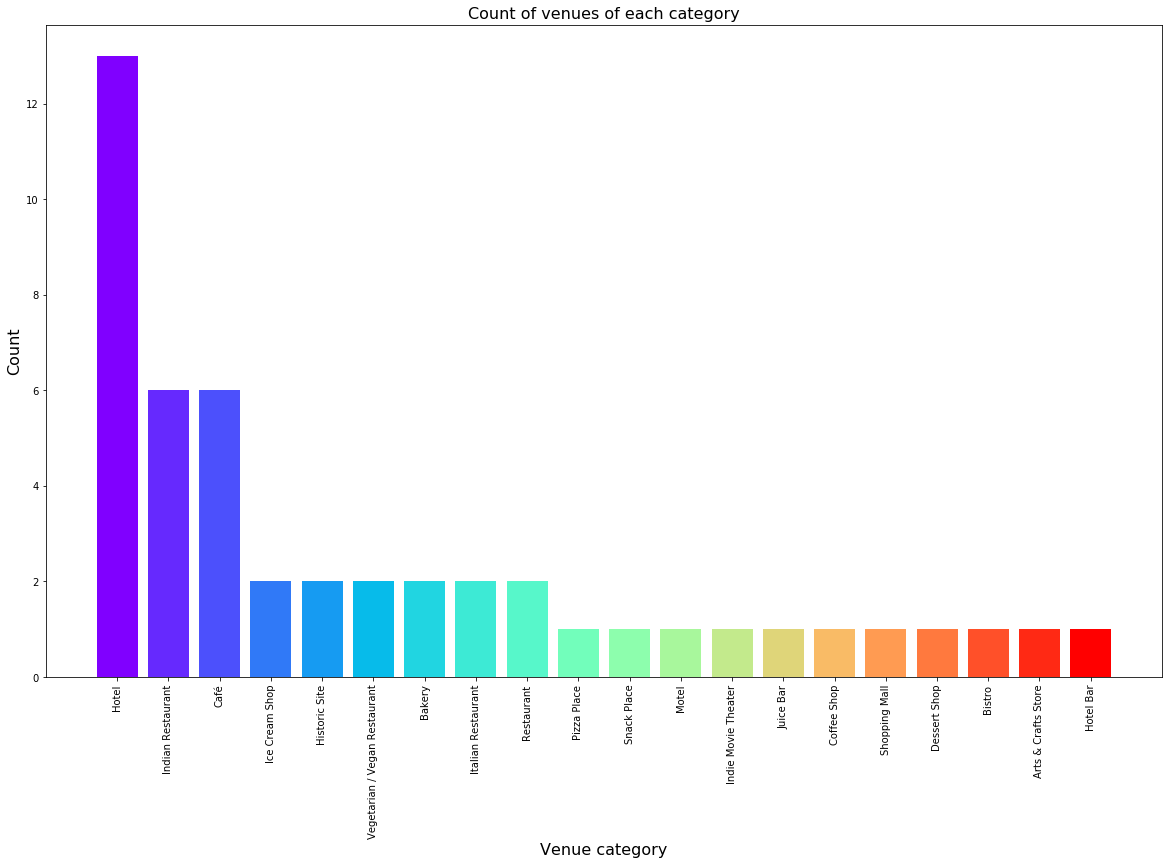

In [19]:
venue_distribution = selected_venues['categories'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(venue_distribution.index)))
plt.figure(figsize = (20, 12))
plt.xticks(rotation = 90)
plt.xlabel("Venue category", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues of each category", fontsize = 16)
plt.bar(venue_distribution.index, venue_distribution.values, color = colors)

Text(0.5, 1.0, 'Count of venues with given rating')

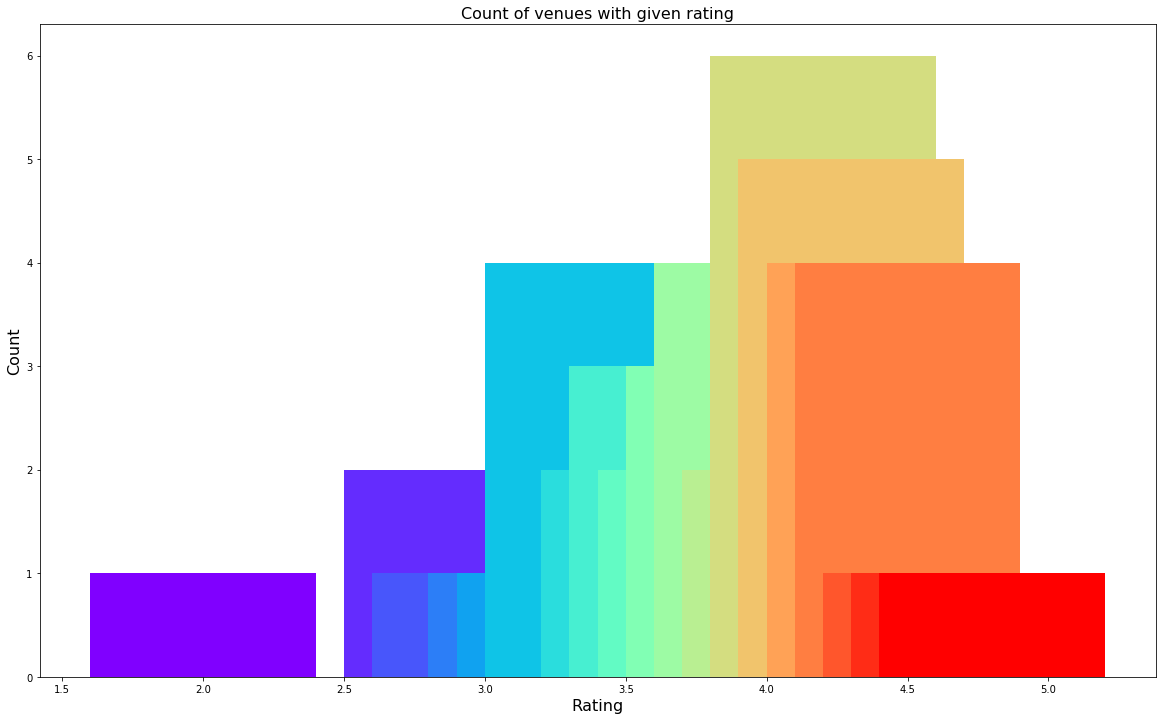

In [20]:
selected_venues['rating'] = selected_venues['rating'].astype(float)
rating = selected_venues['rating'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.bar(rating.index, rating.values, color = cm.rainbow(np.linspace(0, 1, len(rating.index))))
plt.xlabel("Rating", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues with given rating", fontsize = 16)

In [33]:
bins = [1.0, 2.0, 3.0, 4.0, 5.0]
labels = ['Low', 'Okay', 'Good', 'Very good']
selected_venues['rating_bin'] = pd.cut(selected_venues['rating'].astype(float), bins = bins, labels = labels, include_lowest = True)
color_map = {'Low': 'red', 'Okay': 'orange', 'Good': 'green', 'Very good': 'darkgreen'}

jaipur_map = folium.Map(location = [JPR_LATITUDE, JPR_LONGITUDE], zoom_start = 13)

for name, address, latitude, longitude, rating_bin in zip(selected_venues['venue'], 
                                                          selected_venues['address'], 
                                                          selected_venues['latitude'], 
                                                          selected_venues['longitude'], 
                                                          selected_venues['rating_bin']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[rating_bin]),
        popup = label).add_to(jaipur_map)  


jaipur_map

Text(0.5, 1.0, 'Count of venues with given average price')

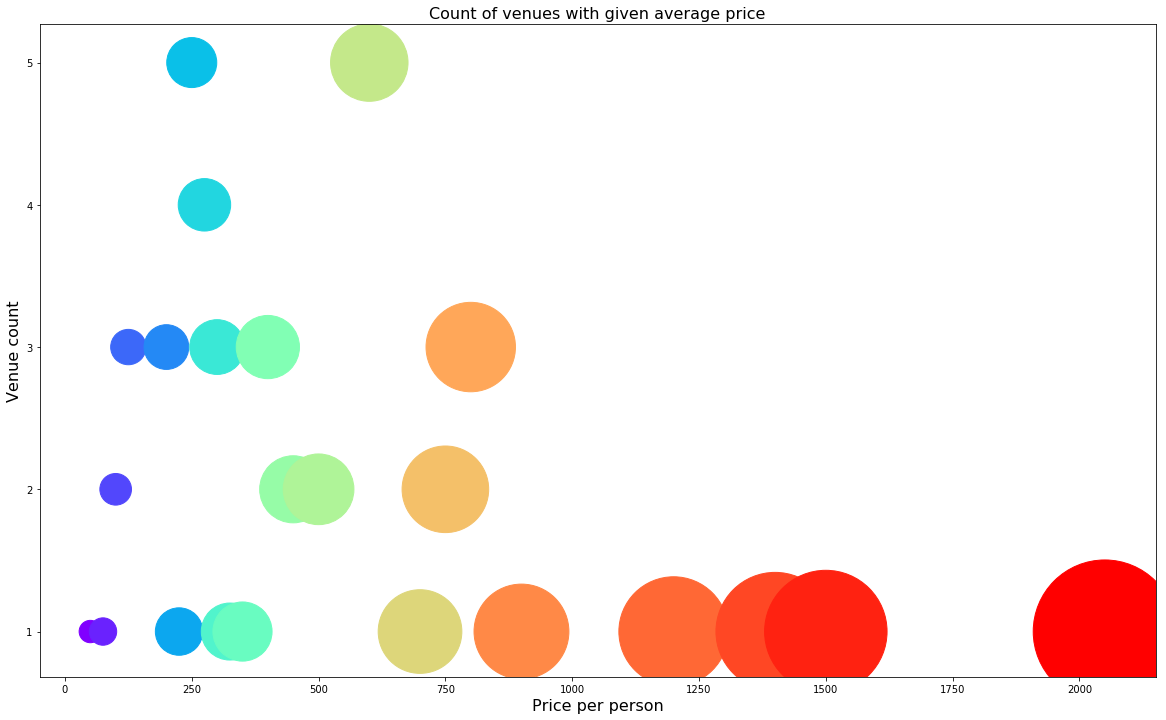

In [22]:
average_prices = selected_venues['average_price'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.scatter(average_prices.index, 
            average_prices.values, 
            s = average_prices.index*10, 
            c = cm.rainbow(np.linspace(0, 1, len(average_prices.index))))
plt.xlabel("Price per person", fontsize = 16)
plt.ylabel("Venue count", fontsize = 16)
plt.title("Count of venues with given average price", fontsize = 16)

In [26]:
color_map = {'1.0': 'green', '2.0': 'darkgreen', '3.0': 'orange', '4.0': 'red'}

jaipur_map = folium.Map(location = [JPR_LATITUDE, JPR_LONGITUDE], zoom_start = 13)

for name, address, latitude, longitude, price_range in zip(selected_venues['venue'], 
                                                           selected_venues['address'], 
                                                           selected_venues['latitude'], 
                                                           selected_venues['longitude'], 
                                                           selected_venues['price_range'].astype(str)):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[price_range]),
        popup = label).add_to(jaipur_map)  


jaipur_map

In [27]:
from sklearn.cluster import KMeans

NO_OF_CLUSTERS = 2

clustering = selected_venues.drop(['venue', 'address', 'rating_bin', 'categories'], 1)
kMeans = KMeans(n_clusters = NO_OF_CLUSTERS, random_state = 0).fit(clustering)
selected_venues.insert(0, 'cluster_labels', kMeans.labels_)
selected_venues.head(5)

,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,1,Indian Restaurant,Peacock,26.9163,75.7957,2.0,4.4,"Hotel Pearl Palace, 51, Near Vidayakpuri Polic...",450.0,Very good
1,1,Ice Cream Shop,Naturals Ice Cream,26.9110,75.7954,1.0,4.7,"A 5, Ground Floor, Suryavanshi Pearl, Sarder P...",75.0,Very good
2,0,Hotel,Rasa,26.9279,75.7878,4.0,3.9,"Shahpura Hotels, D-257, Devi Marg, Bani Park, ...",1200.0,Good
3,1,Indian Restaurant,Spice Court,26.9109,75.7891,3.0,4.2,"Achrol House, Jacob Road, Civil Lines, Jaipur",700.0,Very good
4,1,Café,Curious Life Coffee Roasters- Deer Park,26.9041,75.7971,2.0,3.8,"P 25, Yudhister Marg, Opposite Deer Park, C Sc...",250.0,Good


In [28]:
jaipur_map = folium.Map(location = [JPR_LATITUDE, JPR_LONGITUDE], zoom_start = 13)
color_map = { 0: 'green', 1: 'red'}

# add venues to the map
markers_colors = []
for venue, address, cluster, latitude, longitude in zip(selected_venues['venue'], 
                                                        selected_venues['address'], 
                                                        selected_venues['cluster_labels'], 
                                                        selected_venues['latitude'], 
                                                        selected_venues['longitude']):
    label = folium.Popup(str(venue) + ', ' + str(address), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = color_map[cluster],
        fill = True,
        fill_color = color_map[cluster],
        fill_opacity = 0.7).add_to(jaipur_map)

# add cluster centers to the map
for index, cluster in enumerate(kMeans.cluster_centers_):
    latitude = cluster[0]
    longitude = cluster[1]
    label = folium.Popup("Cluster: " + str(index), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 10,
        popup = label,
        color = color_map[index],
        fill = True,
        fill_color = color_map[index],
        fill_opacity = 0.7).add_to(jaipur_map)


jaipur_map

In [29]:
result = selected_venues[selected_venues['cluster_labels'] == 0]
print("Cluster 0")
result.head(10).reset_index(drop = True)

Cluster 0


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,0,Hotel,Rasa,26.9279,75.7878,4.0,3.9,"Shahpura Hotels, D-257, Devi Marg, Bani Park, ...",1200.0,Good
1,0,Hotel,Steam - Rambagh Palace,26.8981,75.8081,4.0,4.8,"Rambagh Palace, Bhawani Singh Road, C Scheme, ...",1400.0,Very good
2,0,Hotel,Chaandi - Hilton Jaipur,26.9013,75.7838,4.0,4.3,"Hilton Jaipur, 42, Geejgarh House, Hawa Sadak,...",1500.0,Very good
3,0,Hotel Bar,The Polo Bar - Rambagh Palace,26.8981,75.8081,4.0,4.0,"Rambagh Palace, Bhawani Singh Road, C Scheme, ...",2050.0,Good


In [30]:

print("These venues for cluster 0 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 0 have mean price range of 4.00 and rating spread around 4.25


In [31]:
result = selected_venues[selected_venues['cluster_labels'] == 1]
print("Cluster 1")
result.head(10).reset_index(drop = True)

Cluster 1


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,1,Indian Restaurant,Peacock,26.9163,75.7957,2.0,4.4,"Hotel Pearl Palace, 51, Near Vidayakpuri Polic...",450.0,Very good
1,1,Ice Cream Shop,Naturals Ice Cream,26.9110,75.7954,1.0,4.7,"A 5, Ground Floor, Suryavanshi Pearl, Sarder P...",75.0,Very good
2,1,Indian Restaurant,Spice Court,26.9109,75.7891,3.0,4.2,"Achrol House, Jacob Road, Civil Lines, Jaipur",700.0,Very good
3,1,Café,Curious Life Coffee Roasters- Deer Park,26.9041,75.7971,2.0,3.8,"P 25, Yudhister Marg, Opposite Deer Park, C Sc...",250.0,Good
4,1,Snack Place,Rawat Mishthan Bhandar,26.9213,75.7967,2.0,4.3,"Opposite Polovictory Cinema, Station Road, Sin...",300.0,Very good
5,1,Hotel,Chitra Cafeteria,26.9207,75.8043,2.0,4.1,"Arya Niwas Hotel, Behind Amber Towers, Sansar ...",275.0,Very good
6,1,Arts & Crafts Store,Anokhi Cafe,26.9108,75.7984,2.0,4.5,"C 11, 2nd Floor, KK Square, C Scheme, Jaipur",275.0,Very good
7,1,Café,Home Café by Mr Beans,26.9050,75.7940,3.0,4.2,"E 141 A, Sardar Patel Marg, C Scheme, Jaipur",500.0,Very good
8,1,Indie Movie Theater,The Doors,26.9157,75.8101,1.0,3.9,"Khandaka Mansion, Near Raj Mandir Cinema, MI R...",200.0,Good
9,1,Historic Site,Jaipur Dairy,26.9078,75.8047,1.0,2.9,"Near Statue Circle, C Scheme, Jaipur",100.0,Okay


In [32]:

print("These venues for cluster 1 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 1 have mean price range of 2.07 and rating spread around 3.91
